In [1]:
import logging

logging.basicConfig(level=logging.INFO)

# Trains of Though Test Bed: Little Red Riding Hood
<table><tr>
<td><img title="Gustave Doré's engraving of the classic tale" src="figs/image-01.jpg"></td>
<td><img title="Hoodwinked! (2015)" src="figs/image-02.jpg"></td>
</tr></table>

## Preliminaries

Load [`text8` corpus][1].

 [1]: http://mattmahoney.net/dc/textdata.html (About the Test Data)

In [2]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

dataset = api.load('text8')
dictionary = Dictionary(dataset)
corpus = [dictionary.doc2bow(line) for line in dataset]
tfidf = TfidfModel(corpus)

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(253854 unique tokens: ['banishment', 'guigues', 'abz', 'dnsap', 'balanitis']...) from 1701 documents (total 17005207 corpus positions)
INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:calculating IDF weights for 1701 documents and 253853 features (4318888 matrix non-zeros)


Produce word embeddings.

In [3]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

model = Word2Vec(dataset).wv

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=5 retains 71290 unique words (28% of original 253854, drops 182564)
INFO:gensim.models.word2vec:effective_min_count=5 leaves 16718844 word corpus (98% of original 17005207, drops 286363)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 253854 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 38 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 12506280 word corpus (74.8% of prior 16718844)
INFO:gensim.models.base_any2vec:estimated required memory for 71290 words and 100 dimensions: 92677000 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.b

INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 55.56% examples, 767444 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 61.85% examples, 769257 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 67.78% examples, 766693 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 74.43% examples, 771953 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 80.78% examples, 771938 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 86.77% examples, 769986 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 93.42% examples, 773702 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:work

Load the script of [Hoodwinked! (2005)](https://www.imdb.com/title/tt0443536/), the text of the Little Red Cap (Grimm J. and Grimm W., 1812), and the English translation of le Petit Chaperon Rouge (Perrault, 1697).

In [4]:
from gensim.utils import simple_preprocess

def preprocess(f, segment_min_size=100, segment_separator='\n\n'):
    tfidf_combined_segments = []
    combined_segment = []
    for segment in f.read().split(segment_separator):
        combined_segment.extend(simple_preprocess(segment))
        if len(combined_segment) >= segment_min_size:
            tfidf_combined_segment = tfidf[dictionary.doc2bow(combined_segment)]
            tfidf_combined_segments.append(tfidf_combined_segment)
            combined_segment = []
    return tfidf_combined_segments

!test -e hoodwinked.txt || wget http://www.veryabc.cn/movie/uploads/script/hoodwinked.txt
with open('hoodwinked.txt', 'rt') as f:
    hoodwinked = preprocess(f)

!test -e littleredcap.txt || wget https://www.cs.cmu.edu/~spok/grimmtmp/020.txt -O littleredcap.txt
with open('littleredcap.txt', 'rt') as f:
    littleredcap = preprocess(f)

!test -e lrrhood.txt || wget http://textfiles.com/stories/lrrhood.txt
with open('lrrhood.txt', 'rt') as f:
    lrrhood = preprocess(f, segment_separator='\n  ')

## Baseline document representation
As a baseline representation, we use the TF-IDF-weighted average of word embeddings.

In [5]:
import npstreams

def baseline_representation(tfidf_segments):
    return npstreams.mean(
        weight * model.vectors[model.vocab[dictionary.id2token[index]].index]
        for segment in tfidf_segments
        for index, weight in segment
        if dictionary[index] in model.vocab
    )

hoodwinked_baseline = baseline_representation(hoodwinked)
littleredcap_baseline = baseline_representation(littleredcap)
lrrhood_baseline = baseline_representation(lrrhood)

In [6]:
from sklearn.manifold import MDS

baselines_mds = MDS()
baselines_2d = baselines_mds.fit_transform((hoodwinked_baseline, littleredcap_baseline, lrrhood_baseline))
hoodwinked_baseline_2d, littleredcap_baseline_2d, lrrhood_baseline_2d = baselines_2d

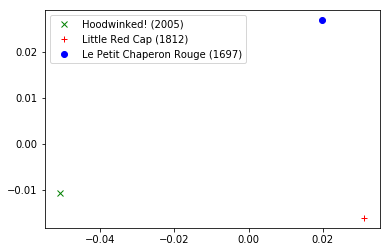

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(*zip(hoodwinked_baseline_2d), 'gx', label='Hoodwinked! (2005)')
ax.plot(*zip(littleredcap_baseline_2d), 'r+', label='Little Red Cap (1812)')
ax.plot(*zip(lrrhood_baseline_2d), 'bo', label='Le Petit Chaperon Rouge (1697)')
plt.legend(loc='best')
plt.savefig('figs/baseline.pdf')
plt.show()

In [8]:
import numpy as np
from scipy.spatial.distance import cosine

print('Hoodwinked (2015) and Little Red Cap (1812)')
print('===========================================')
euclidean_distance = np.linalg.norm(hoodwinked_baseline - littleredcap_baseline)
cosine_similarity = 1 - cosine(hoodwinked_baseline, littleredcap_baseline)
print('Euclidean distance:\t{}'.format(euclidean_distance))
print('Cosine similarity:\t{}'.format(cosine_similarity))

print()
print('Hoodwinked (2015) and Le Petit Chaperon Rouge (Perrault, 1697)')
print('==============================================================')
euclidean_distance = np.linalg.norm(hoodwinked_baseline - lrrhood_baseline)
cosine_similarity = 1 - cosine(hoodwinked_baseline, lrrhood_baseline)
print('Euclidean distance:\t{}'.format(euclidean_distance))
print('Cosine similarity:\t{}'.format(cosine_similarity))

print()
print('Little Red Cap (1812) and Le Petit Chaperon Rouge (Perrault, 1697)')
print('==================================================================')
euclidean_distance = np.linalg.norm(littleredcap_baseline - lrrhood_baseline)
cosine_similarity = 1 - cosine(littleredcap_baseline, lrrhood_baseline)
print('Euclidean distance:\t{}'.format(euclidean_distance))
print('Cosine similarity:\t{}'.format(cosine_similarity))

Hoodwinked (2015) and Little Red Cap (1812)
Euclidean distance:	0.08300464478092617
Cosine similarity:	0.8989178348872029

Hoodwinked (2015) and Le Petit Chaperon Rouge (Perrault, 1697)
Euclidean distance:	0.07987683199808436
Cosine similarity:	0.9105910032645207

Little Red Cap (1812) and Le Petit Chaperon Rouge (Perrault, 1697)
Euclidean distance:	0.04297073004700235
Cosine similarity:	0.9747556087682396


## Curve representation

As a primary representation, we use curves constructed from baseline representations of segments.

In [9]:
import npstreams
from sklearn import preprocessing

def curve_representation(tfidf_segments):
    curve = [
        npstreams.mean(
            weight * model.vectors[model.vocab[dictionary.id2token[index]].index]
            for index, weight in segment
            if dictionary[index] in model.vocab
        )
        for segment in tfidf_segments
    ]
    return list(preprocessing.scale(curve, with_std=False, with_mean=False))

hoodwinked_curve = curve_representation(hoodwinked)
littleredcap_curve = curve_representation(littleredcap)
lrrhood_curve = curve_representation(lrrhood)

In [10]:
from sklearn.manifold import MDS

curves_mds = MDS()
curves_2d = curves_mds.fit_transform(
    hoodwinked_curve + littleredcap_curve + lrrhood_curve + [
        hoodwinked_baseline,
        littleredcap_baseline,
        lrrhood_baseline,
    ]
)
hoodwinked_curve_2d = curves_2d[:len(hoodwinked_curve)]
littleredcap_curve_2d = curves_2d[len(hoodwinked_curve):len(hoodwinked_curve) + len(littleredcap_curve)]
lrrhood_curve_2d = curves_2d[len(hoodwinked_curve) + len(littleredcap_curve):-3]
hoodwinked_baseline_2d = curves_2d[-3]
littleredcap_baseline_2d = curves_2d[-2]
lrrhood_baseline_2d = curves_2d[-1]

In [11]:
import numpy as np
from scipy.interpolate import splprep, splev

def smooth_curve(curve, step_size=0.001):
    smooth_u = np.arange(0, 1, step_size)
    tck, u = splprep(tuple(zip(*curve)), s=0)
    smooth_curve = tuple(zip(*splev(smooth_u, tck)))
    return smooth_curve

hoodwinked_smooth_curve_2d = smooth_curve(hoodwinked_curve_2d)
littleredcap_smooth_curve_2d = smooth_curve(littleredcap_curve_2d)
lrrhood_smooth_curve_2d = smooth_curve(lrrhood_curve_2d)

In [12]:
%%capture
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from os import getcwd

fig, ax = plt.subplots(figsize=(20, 10))
hoodwinked_line, = ax.plot(*zip(*hoodwinked_smooth_curve_2d), 'g-', label='Hoodwinked! (2005)')
littleredcap_line, = ax.plot(*zip(*littleredcap_smooth_curve_2d), 'r-', label='Little Red Cap (1812)')
lrrhood_line, = ax.plot(*zip(*lrrhood_smooth_curve_2d), 'b-', label='Le Petit Chaperon Rouge (1697)')
plt.legend(loc='upper right')

def update(num):
    hoodwinked_line.set_data(*zip(*hoodwinked_smooth_curve_2d[:num + 1]))
    littleredcap_line.set_data(*zip(*littleredcap_smooth_curve_2d[:num + 1]))
    lrrhood_line.set_data(*zip(*lrrhood_smooth_curve_2d[:num + 1]))
    return hoodwinked_line, littleredcap_line, lrrhood_line

ani = animation.FuncAnimation(fig, update, len(hoodwinked_smooth_curve_2d), interval=10)
ani.save('{}/figs/curves.mp4'.format(getcwd()))

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1440x720', '-pix_fmt', 'rgba', '-r', '100.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/home/witiko/documents/Škola/Vysoká škola/13. semestr/PV212 - Seminar on DT, SV, IR, and ML/Repozitáře/trains-of-thought-hoodwinked/figs/curves.mp4']


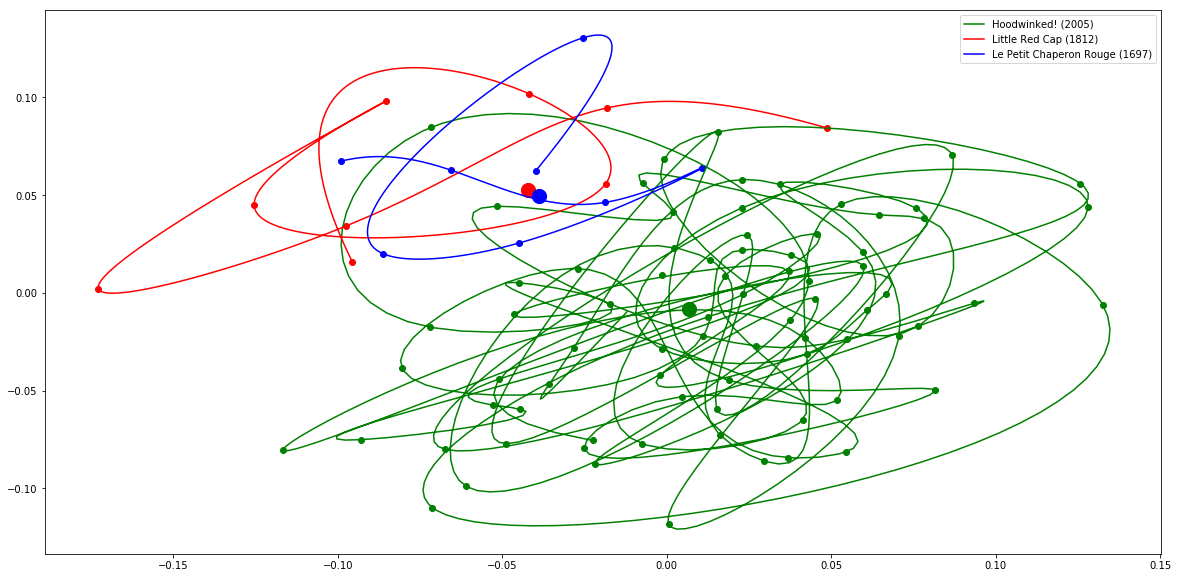

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(*zip(*hoodwinked_smooth_curve_2d), 'g-', label='Hoodwinked! (2005)')
ax.scatter(*zip(*hoodwinked_curve_2d), color='g')
ax.scatter(*zip(hoodwinked_baseline_2d), 200, color='g')

ax.plot(*zip(*littleredcap_smooth_curve_2d), 'r-', label='Little Red Cap (1812)')
ax.scatter(*zip(*littleredcap_curve_2d), color='r')
ax.scatter(*zip(littleredcap_baseline_2d), 200, color='r')

ax.plot(*zip(*lrrhood_smooth_curve_2d), 'b-', label='Le Petit Chaperon Rouge (1697)')
ax.scatter(*zip(*lrrhood_curve_2d), color='b') 
ax.scatter(*zip(lrrhood_baseline_2d), 200, color='b')

plt.legend(loc='upper right')
plt.savefig('figs/curves.pdf')
plt.show()

### Dynamic Time Warping
As one measure of distance between the curves, we compute the [dynamic time warping][1] (DTW) using the [FastDTW method][2] (Salvador and Chan, 2007).

 [1]: https://en.wikipedia.org/wiki/Dynamic_time_warping (Dynamic time warping)
 [2]: https://content.iospress.com/articles/intelligent-data-analysis/ida00303 (Toward accurate dynamic time warping in linear time and space)

In [14]:
littleredcap_smooth_curve_2d_shifted = [
    (x + 0.2, y - 0.2)
    for x, y in littleredcap_smooth_curve_2d
]
littleredcap_curve_2d_shifted = [
    (x + 0.2, y - 0.2)
    for x, y in littleredcap_curve_2d
]

lrrhood_smooth_curve_2d_shifted = [
    (x - 0.2, y - 0.2)
    for x, y in lrrhood_smooth_curve_2d
]
lrrhood_curve_2d_shifted = [
    (x - 0.2, y - 0.2)
    for x, y in lrrhood_curve_2d
]

/home/witiko/.virtualenvs/trains-of-thought-hoodwinked/local/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if __name__ == '__main__':
/home/witiko/.virtualenvs/trains-of-thought-hoodwinked/local/lib/python3.5/site-packages/ipykernel_launcher.py:18: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/home/witiko/.virtualenvs/trains-of-thought-hoodwinked/local/lib/python3.5/site-packages/ipykernel_launcher.py:27: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


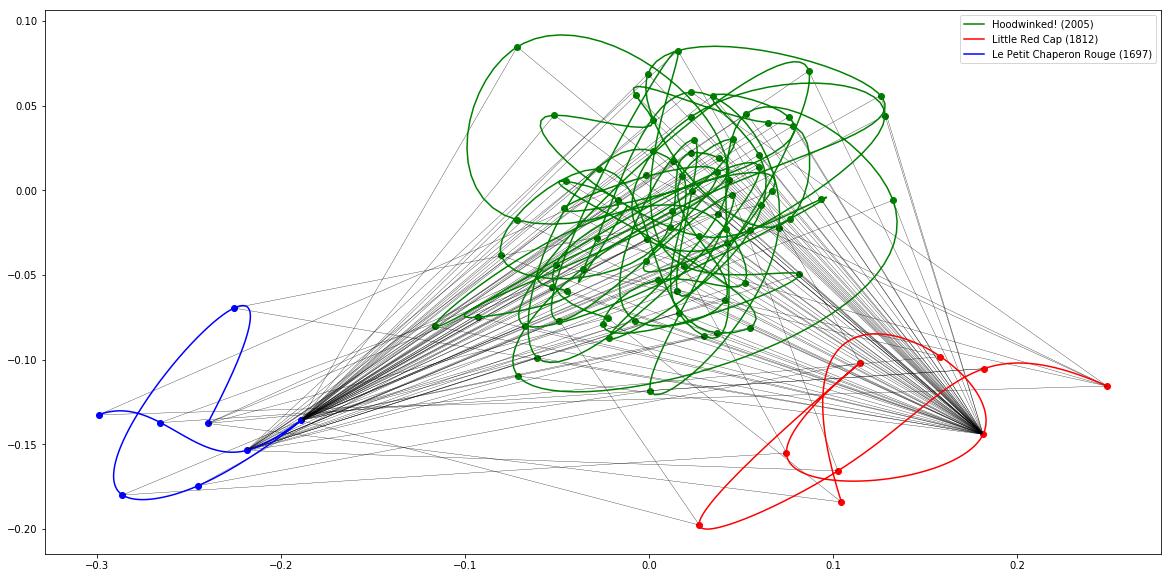

In [15]:
%matplotlib inline
from fastdtw import fastdtw
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

fig, ax = plt.subplots(figsize=(20, 10))

_, path = fastdtw(np.array(hoodwinked_curve), np.array(lrrhood_curve))
for hoodwinked_index, lrrhood_index in path:
    ax.plot(
        *zip(hoodwinked_curve_2d[hoodwinked_index],
        lrrhood_curve_2d_shifted[lrrhood_index]),
        'k-',
        linewidth=0.3,
    )

_, path = fastdtw(np.array(hoodwinked_curve), np.array(littleredcap_curve))
for hoodwinked_index, littleredcap_index in path:
    ax.plot(
        *zip(hoodwinked_curve_2d[hoodwinked_index],
        littleredcap_curve_2d_shifted[littleredcap_index]),
        'k-',
        linewidth=0.3,
    )

_, path = fastdtw(np.array(littleredcap_curve), np.array(lrrhood_curve))
for littleredcap_index, lrrhood_index in path:
    ax.plot(
        *zip(littleredcap_curve_2d_shifted[littleredcap_index],
        lrrhood_curve_2d_shifted[lrrhood_index]),
        'k-',
        linewidth=0.3,
    )

ax.plot(*zip(*hoodwinked_smooth_curve_2d), 'g-', label='Hoodwinked! (2005)')
ax.scatter(*zip(*hoodwinked_curve_2d), color='g')

ax.plot(*zip(*littleredcap_smooth_curve_2d_shifted), 'r-', label='Little Red Cap (1812)')
ax.scatter(*zip(*littleredcap_curve_2d_shifted), color='r')

ax.plot(*zip(*lrrhood_smooth_curve_2d_shifted), 'b-', label='Le Petit Chaperon Rouge (1697)')
ax.scatter(*zip(*lrrhood_curve_2d_shifted), color='b')

plt.legend(loc='upper right')
plt.savefig('figs/dtw.pdf')
plt.show()

First, compute the DWT between the curves, where every curve is represented by a different number of points.

In [16]:
from fastdtw import fastdtw
import numpy as np
from scipy.spatial.distance import euclidean, cosine

print('Hoodwinked (2015) and Little Red Cap (1812)')
print('===========================================')
euclidean_distance, euclidean_path = fastdtw(
    np.array(hoodwinked_curve),
    np.array(littleredcap_curve),
    dist=euclidean,
)
euclidean_distance /= len(euclidean_path)
cosine_distance, cosine_path = fastdtw(
    np.array(hoodwinked_curve),
    np.array(littleredcap_curve),
    dist=cosine,
)
cosine_distance /= len(cosine_path)
cosine_similarity = 1 - cosine_distance
print('Average euclidean distance:\t{}'.format(euclidean_distance))
print('Average cosine similarity:\t{}'.format(cosine_similarity))

print()
print('Hoodwinked (2015) and Le Petit Chaperon Rouge (Perrault, 1697)')
print('==============================================================')
euclidean_distance, euclidean_path = fastdtw(
    np.array(hoodwinked_curve),
    np.array(lrrhood_curve),
    dist=euclidean,
)
euclidean_distance /= len(euclidean_path)
cosine_distance, cosine_path = fastdtw(
    np.array(hoodwinked_curve),
    np.array(lrrhood_curve),
    dist=cosine,
)
cosine_distance /= len(cosine_path)
cosine_similarity = 1 - cosine_distance
print('Average euclidean distance:\t{}'.format(euclidean_distance))
print('Average cosine similarity:\t{}'.format(cosine_similarity))

print()
print('Little Red Cap (1812) and Le Petit Chaperon Rouge (Perrault, 1697)')
print('==================================================================')
euclidean_distance, euclidean_path = fastdtw(
    np.array(littleredcap_curve),
    np.array(lrrhood_curve),
    dist=euclidean,
)
euclidean_distance /= len(euclidean_path)
cosine_distance, cosine_path = fastdtw(
    np.array(littleredcap_curve),
    np.array(lrrhood_curve),
    dist=cosine,
)
cosine_distance /= len(cosine_path)
cosine_similarity = 1 - cosine_distance
print('Average euclidean distance:\t{}'.format(euclidean_distance))
print('Average cosine similarity:\t{}'.format(cosine_similarity))

Hoodwinked (2015) and Little Red Cap (1812)
Average euclidean distance:	0.10933866169649152
Average cosine similarity:	0.8435894347881666

Hoodwinked (2015) and Le Petit Chaperon Rouge (Perrault, 1697)
Average euclidean distance:	0.10435959547556081
Average cosine similarity:	0.8546264482952375

Little Red Cap (1812) and Le Petit Chaperon Rouge (Perrault, 1697)
Average euclidean distance:	0.10808265502676566
Average cosine similarity:	0.9171274741807279


Next, use linear interpolation to supersample the curves, so that every curve is represented by the same number of points.

In [17]:
from math import floor, ceil

import numpy as np

def interpolate(curve, u):
    index = u * (len(curve) - 1)
    return (
        curve[int(floor(index))] * (ceil(index) - index) +
        curve[int(ceil(index))] * (1.0 - (ceil(index) - index))
    )

def sample_curve(curve, step_size=0.01):
    return [
        interpolate(curve, u)
        for u in np.arange(0, 1, step_size)
    ]

hoodwinked_sampled_curve = sample_curve(hoodwinked_curve)
littleredcap_sampled_curve = sample_curve(littleredcap_curve)
lrrhood_sampled_curve = sample_curve(lrrhood_curve)

In [18]:
from fastdtw import fastdtw
import numpy as np
from scipy.spatial.distance import euclidean, cosine

print('Hoodwinked (2015) and Little Red Cap (1812)')
print('===========================================')
euclidean_distance, euclidean_path = fastdtw(
    np.array(hoodwinked_sampled_curve),
    np.array(littleredcap_sampled_curve),
    dist=euclidean,
)
euclidean_distance /= len(euclidean_path)
cosine_distance, cosine_path = fastdtw(
    np.array(hoodwinked_sampled_curve),
    np.array(littleredcap_sampled_curve),
    dist=cosine,
)
cosine_distance /= len(cosine_path)
cosine_similarity = 1 - cosine_distance
print('Average euclidean distance:\t{}'.format(euclidean_distance))
print('Average cosine similarity:\t{}'.format(cosine_similarity))

print()
print('Hoodwinked (2015) and Le Petit Chaperon Rouge (Perrault, 1697)')
print('==============================================================')
euclidean_distance, euclidean_path = fastdtw(
    np.array(hoodwinked_sampled_curve),
    np.array(lrrhood_sampled_curve),
    dist=euclidean,
)
euclidean_distance /= len(euclidean_path)
cosine_distance, cosine_path = fastdtw(
    np.array(hoodwinked_sampled_curve),
    np.array(lrrhood_sampled_curve),
    dist=cosine,
)
cosine_distance /= len(cosine_path)
cosine_similarity = 1 - cosine_distance
print('Average euclidean distance:\t{}'.format(euclidean_distance))
print('Average cosine similarity:\t{}'.format(cosine_similarity))

print()
print('Little Red Cap (1812) and Le Petit Chaperon Rouge (Perrault, 1697)')
print('==================================================================')
euclidean_distance, euclidean_path = fastdtw(
    np.array(littleredcap_sampled_curve),
    np.array(lrrhood_sampled_curve),
    dist=euclidean,
)
euclidean_distance /= len(euclidean_path)
cosine_distance, cosine_path = fastdtw(
    np.array(littleredcap_sampled_curve),
    np.array(lrrhood_sampled_curve),
    dist=cosine,
)
cosine_distance /= len(cosine_path)
cosine_similarity = 1 - cosine_distance
print('Average euclidean distance:\t{}'.format(euclidean_distance))
print('Average cosine similarity:\t{}'.format(cosine_similarity))

Hoodwinked (2015) and Little Red Cap (1812)
Average euclidean distance:	0.1319153532677336
Average cosine similarity:	0.8244236906368468

Hoodwinked (2015) and Le Petit Chaperon Rouge (Perrault, 1697)
Average euclidean distance:	0.10690834355398135
Average cosine similarity:	0.8469889368838383

Little Red Cap (1812) and Le Petit Chaperon Rouge (Perrault, 1697)
Average euclidean distance:	0.09253629361106452
Average cosine similarity:	0.9419421873463346


### Generalized Bresenheim's Line Algorithm and the Longest Common Subsequence
We use the [Bresenham's line algorithm][1] generalized to high dimensions and arbitrary grids to compute the voxel representation of the line segments between the points of a curve. We then compute the similarity of two curves as the [Longest Common Subsequence][2] (an $\textsf{NP}$-hard problem).

 [1]: https://en.wikipedia.org/wiki/Dynamic_time_warping (Dynamic time warping)
 [2]: https://en.wikipedia.org/wiki/Longest_common_subsequence_problem (Longest common subsequence problem)

In [19]:
from math import floor, ceil

import numpy as np

def snap_to_grid(point, grid_interval=0.1):
    return np.round(point / grid_interval) * grid_interval

def interpolate(first_point, second_point, u):
    return first_point * u + second_point * (1.0 - u)

def bresenheim(curve, grid_interval=0.1):
    points = []
    for first_point, second_point in zip(curve[:-1], curve[1:]):
        first_point = snap_to_grid(first_point, grid_interval)
        second_point = snap_to_grid(second_point, grid_interval)
        if np.all(first_point == second_point):
            points.append(first_point)
            continue
        slowest_dimension = np.argmax(np.abs(second_point - first_point))
        total_distance = second_point[slowest_dimension] - first_point[slowest_dimension]
        for travelled_distance in np.arange(0, total_distance, np.sign(total_distance) * grid_interval):
            u = travelled_distance / total_distance
            current_point = snap_to_grid(first_point * u + second_point * (1.0 - u), grid_interval)
            points.append(current_point)
    points.append(second_point)
    return points

hoodwinked_curve_voxels = bresenheim(hoodwinked_curve)
littleredcap_curve_voxels = bresenheim(littleredcap_curve)
lrrhood_curve_voxels = bresenheim(lrrhood_curve)

In [20]:
from sklearn.manifold import MDS

curve_voxels_mds = MDS()
curve_voxels_2d = curve_voxels_mds.fit_transform(
    hoodwinked_curve_voxels + littleredcap_curve_voxels + lrrhood_curve_voxels + [
        hoodwinked_baseline,
        littleredcap_baseline,
        lrrhood_baseline,
    ]
)
hoodwinked_curve_voxels_2d = curve_voxels_2d[:len(hoodwinked_curve)]
littleredcap_curve_voxels_2d = curve_voxels_2d[len(hoodwinked_curve):len(hoodwinked_curve) + len(littleredcap_curve)]
lrrhood_curve_voxels_2d = curve_voxels_2d[len(hoodwinked_curve) + len(littleredcap_curve):-3]
hoodwinked_baseline_voxels_2d = curve_voxels_2d[-3]
littleredcap_baseline_voxels_2d = curve_voxels_2d[-2]
lrrhood_baseline_voxels_2d = curve_voxels_2d[-1]

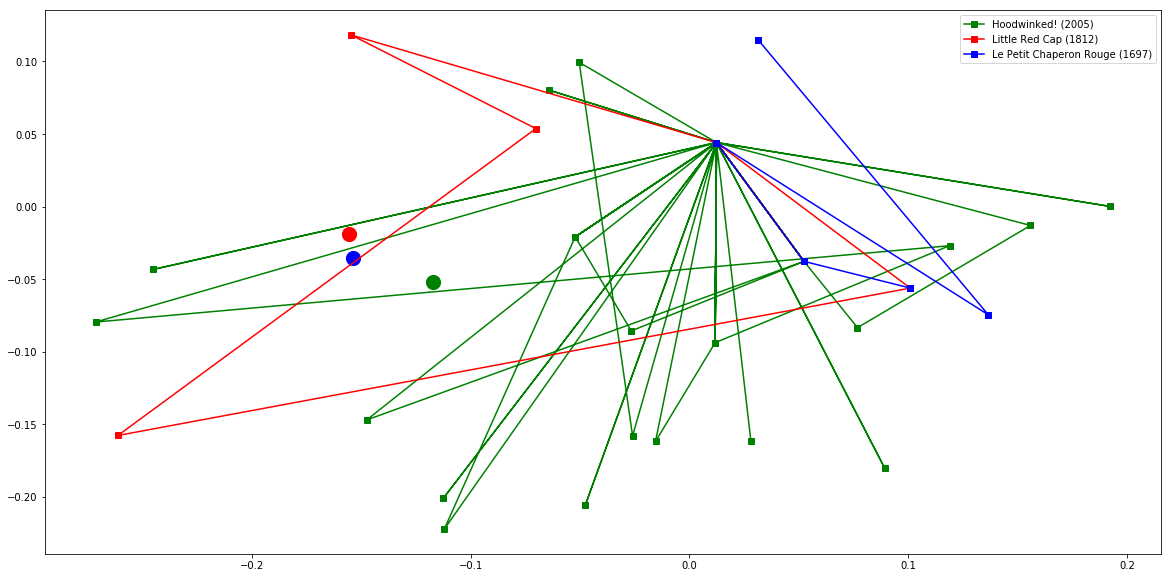

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(*zip(*hoodwinked_curve_voxels_2d), 'gs-', label='Hoodwinked! (2005)')
ax.scatter(*zip(hoodwinked_baseline_voxels_2d), 200, color='g')

ax.plot(*zip(*littleredcap_curve_voxels_2d), 'rs-', label='Little Red Cap (1812)')
ax.scatter(*zip(littleredcap_baseline_voxels_2d), 200, color='r')

ax.plot(*zip(*lrrhood_curve_voxels_2d), 'bs-', label='Le Petit Chaperon Rouge (1697)')
ax.scatter(*zip(lrrhood_baseline_voxels_2d), 200, color='b')

plt.legend(loc='upper right')
plt.savefig('figs/voxels.pdf')
plt.show()

In [22]:
cache = {}

def memoize(fn):
    def inner(*args):
        try:
            return cache[args]
        except KeyError:
            cache[args] = fn(*args)
            return cache[args]
    return inner

@memoize
def lcs(s1, s2):
    if not s1 or not s2:
        return 0

    return (
        1 + lcs(s1[:-1], s2[:-1])
        if s1[-1] == s2[-1] else
        max(lcs(s1[:-1], s2), lcs(s1, s2[:-1]))
    )

print('Hoodwinked (2015) and Little Red Cap (1812)')
print('===========================================')
curve_similarity = lcs(
    tuple(tuple(point) for point in hoodwinked_curve_voxels),
    tuple(tuple(point) for point in littleredcap_curve_voxels),
)
print('Longest Common Subsequence:\t{}\t({:.2f} % of query, {:.2f} % of result, {:.2f} % of union)'.format(
    curve_similarity,
    float(curve_similarity) / len(hoodwinked_curve_voxels) * 100,
    float(curve_similarity) / len(littleredcap_curve_voxels) * 100,
    float(curve_similarity) / (
        len(hoodwinked_curve_voxels) + len(littleredcap_curve_voxels) - curve_similarity
    ) * 100
))

print()
print('Hoodwinked (2015) and Le Petit Chaperon Rouge (Perrault, 1697)')
print('==============================================================')
curve_similarity = lcs(
    tuple(tuple(point) for point in hoodwinked_curve_voxels),
    tuple(tuple(point) for point in lrrhood_curve_voxels),
)
print('Longest Common Subsequence:\t{}\t({:.2f} % of query, {:.2f} % of result, {:.2f} % of union)'.format(
    curve_similarity,
    float(curve_similarity) / len(hoodwinked_curve_voxels) * 100,
    float(curve_similarity) / len(lrrhood_curve_voxels) * 100,
    float(curve_similarity) / (
        len(hoodwinked_curve_voxels) + len(lrrhood_curve_voxels) - curve_similarity
    ) * 100
))

print()
print('Little Red Cap (1812) and Le Petit Chaperon Rouge (Perrault, 1697)')
print('==================================================================')
curve_similarity = lcs(
    tuple(tuple(point) for point in littleredcap_curve_voxels),
    tuple(tuple(point) for point in lrrhood_curve_voxels),
)
print('Longest Common Subsequence:\t{}\t({:.2f} % of query, {:.2f} % of result, {:.2f} % of union)'.format(
    curve_similarity,
    float(curve_similarity) / len(littleredcap_curve_voxels) * 100,
    float(curve_similarity) / len(lrrhood_curve_voxels) * 100,
    float(curve_similarity) / (
        len(littleredcap_curve_voxels) + len(lrrhood_curve_voxels) - curve_similarity
    ) * 100
))

Hoodwinked (2015) and Little Red Cap (1812)
Longest Common Subsequence:	5	(6.49 % of query, 55.56 % of result, 6.17 % of union)

Hoodwinked (2015) and Le Petit Chaperon Rouge (Perrault, 1697)
Longest Common Subsequence:	4	(5.19 % of query, 50.00 % of result, 4.94 % of union)

Little Red Cap (1812) and Le Petit Chaperon Rouge (Perrault, 1697)
Longest Common Subsequence:	4	(44.44 % of query, 50.00 % of result, 30.77 % of union)
